In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100
pd.options.display.max_columns = None

columns1=[
'data_date',
'cust_code',
'emp_type',
'country_residence',
'sex',
'age',
'join_date',
'new_cust',
'antiquity',
'first_cust',
'last_date_first_cust',
'cust_type',
'cust_rel',
'residence' ,
'foreigner' ,
'emp_spouse',
'channel',
'deceased',
'address_type',
'province_code',
'province_name',
'cust_activity',
'gross_income',
'segmentation',
'saving_account',
'guarantees',
'current_accounts',
'derivative_account',
'payroll_account',
'junior_account',
'more_particular_account',
'particular_account',
'particular_plus_account',
'short_term_deposits',
'medium_term_deposits',
'long_term_deposits',
'e_account',
'funds',
'mortgage',
'plan_pensions',
'loans',
'taxes',
'credit_card',
'securities',
'home_Account',
'payroll',
'nom_pensions',
'direct_debit',

]


In [2]:
import pandas as pd
from pyspark.sql import SparkSession
#from pyspark.context import SparkContext
spark = SparkSession.builder.getOrCreate()
import time

In [8]:
orders = spark.read.options(header='True',inferSchema='True',delimiter=',') \
.csv("C:/Users/yashk/Desktop/ADM/Projects/sample_train_100K.csv")
orders.printSchema()

root
 |-- fecha_dato: string (nullable = true)
 |-- ncodpers: integer (nullable = true)
 |-- ind_empleado: string (nullable = true)
 |-- pais_residencia: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- age: string (nullable = true)
 |-- fecha_alta: string (nullable = true)
 |-- ind_nuevo: string (nullable = true)
 |-- antiguedad: string (nullable = true)
 |-- indrel: string (nullable = true)
 |-- ult_fec_cli_1t: string (nullable = true)
 |-- indrel_1mes: string (nullable = true)
 |-- tiprel_1mes: string (nullable = true)
 |-- indresi: string (nullable = true)
 |-- indext: string (nullable = true)
 |-- conyuemp: string (nullable = true)
 |-- canal_entrada: string (nullable = true)
 |-- indfall: string (nullable = true)
 |-- tipodom: string (nullable = true)
 |-- cod_prov: string (nullable = true)
 |-- nomprov: string (nullable = true)
 |-- ind_actividad_cliente: string (nullable = true)
 |-- renta: double (nullable = true)
 |-- segmento: string (nullable = true)
 |-- i

In [9]:
df2=(orders.columns)
prod_cols=df2[24:]
more_cols=["ncodpers"]

list3=more_cols+prod_cols
list3

['ncodpers',
 'ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

In [12]:

from pyspark import SparkContext

sc = SparkContext.getOrCreate();


In [14]:

orders=orders.dropDuplicates(list3)


In [15]:
list3
orders.createOrReplaceTempView('orders') 

In [17]:

from pyspark.sql.types import DateType
from datetime import datetime
from pyspark.sql.functions import *
func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

z = orders.withColumn('fecha_dato2', func(col('fecha_dato')))



z.printSchema()

root
 |-- fecha_dato: string (nullable = true)
 |-- ncodpers: integer (nullable = true)
 |-- ind_empleado: string (nullable = true)
 |-- pais_residencia: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- age: string (nullable = true)
 |-- fecha_alta: string (nullable = true)
 |-- ind_nuevo: string (nullable = true)
 |-- antiguedad: string (nullable = true)
 |-- indrel: string (nullable = true)
 |-- ult_fec_cli_1t: string (nullable = true)
 |-- indrel_1mes: string (nullable = true)
 |-- tiprel_1mes: string (nullable = true)
 |-- indresi: string (nullable = true)
 |-- indext: string (nullable = true)
 |-- conyuemp: string (nullable = true)
 |-- canal_entrada: string (nullable = true)
 |-- indfall: string (nullable = true)
 |-- tipodom: string (nullable = true)
 |-- cod_prov: string (nullable = true)
 |-- nomprov: string (nullable = true)
 |-- ind_actividad_cliente: string (nullable = true)
 |-- renta: double (nullable = true)
 |-- segmento: string (nullable = true)
 |-- i

In [18]:
from pyspark.sql.functions import to_date, datediff, min, max, sum, countDistinct, expr
 
a = z
 
c = (
  z                                                          
    .groupBy()
      .agg(
        max((z.fecha_dato2)).alias('current_date')
        )
  )

rfm = (
  a
    .filter(a.ncodpers.isNotNull())
    .crossJoin(c)
    .groupBy(a.ncodpers)
      .agg(
        min(datediff(c.current_date, a.fecha_dato2)).alias('recency'),
        countDistinct(a.fecha_dato2).alias('frequency')
        )
     
  ).orderBy(a.ncodpers)
 
rfm.createOrReplaceTempView('rfm')
display(rfm)

DataFrame[ncodpers: int, recency: int, frequency: bigint]

In [19]:

 
a = orders
a.count()


95542

In [20]:
# extract the quantile cutoffs for each metric
import numpy as np
r_quantile = rfm.approxQuantile('recency', np.linspace(0.1, 0.9, num=9).tolist(), 0)
f_quantile = rfm.approxQuantile('frequency',np.linspace(0.1, 0.9, num=9).tolist(), 0)

 

In [21]:
from pyspark.sql.functions import when
 
# extract the quantile cutoffs for each metric
#r_quantile = rfm.approxQuantile('recency', np.linspace(0.1, 0.9, num=9).tolist(), 0)
#f_quantile = rfm.approxQuantile('frequency',np.linspace(0.1, 0.9, num=9).tolist(), 0)
#m_quantile = rfm.approxQuantile('monetary_value', np.linspace(0.1, 0.9, num=9).tolist(), 0)
 
scores = (
  rfm
      .withColumn('recency_score',
        when(rfm.recency >= r_quantile[8], 1).
        when(rfm.recency >= r_quantile[7] , 2).
        when(rfm.recency >= r_quantile[6] , 3).
        when(rfm.recency >= r_quantile[5] , 4).
        when(rfm.recency >= r_quantile[4] , 5).
        when(rfm.recency >= r_quantile[3] , 6).
        when(rfm.recency >= r_quantile[2] , 7).
        when(rfm.recency >= r_quantile[1] , 8).
        when(rfm.recency >= r_quantile[0] , 9).
        otherwise(10)
        )
    .withColumn('frequency_score', 
        when(rfm.frequency > f_quantile[8], 10).
        when(rfm.frequency > f_quantile[7] , 9).
        when(rfm.frequency > f_quantile[6] , 8).
        when(rfm.frequency > f_quantile[5] , 7).
        when(rfm.frequency > f_quantile[4] , 6).
        when(rfm.frequency > f_quantile[3] , 5).
        when(rfm.frequency > f_quantile[2] , 4).
        when(rfm.frequency > f_quantile[1] , 3).
        when(rfm.frequency > f_quantile[0] , 2).
        otherwise(1)
        )
    
    .select('ncodpers','recency','recency_score','frequency','frequency_score')
    .orderBy('ncodpers')
    )
 
display(scores)

DataFrame[ncodpers: int, recency: int, recency_score: int, frequency: bigint, frequency_score: int]

In [34]:
display(scores)
scores.show(truncate=False)

DataFrame[ncodpers: int, recency: int, recency_score: int, frequency: bigint, frequency_score: int]

+--------+-------+-------------+---------+---------------+
|ncodpers|recency|recency_score|frequency|frequency_score|
+--------+-------+-------------+---------+---------------+
|15890   |396    |2            |1        |1              |
|15892   |305    |3            |1        |1              |
|15899   |274    |4            |1        |1              |
|15900   |90     |8            |1        |1              |
|15918   |396    |2            |1        |1              |
|15935   |366    |2            |1        |1              |
|15957   |182    |6            |1        |1              |
|15965   |30     |9            |1        |1              |
|15976   |0      |10           |1        |1              |
|15990   |90     |8            |1        |1              |
|15993   |0      |10           |1        |1              |
|15994   |90     |8            |1        |1              |
|16028   |243    |4            |1        |1              |
|16031   |366    |2            |1        |1             

In [22]:
from sklearn.manifold import TSNE
 
# retrieve scores (move CustomerID to index to make later review easier)
scores_pd = scores.select('ncodpers', 'recency_score', 'frequency_score').toPandas()
scores_pd.set_index('ncodpers', drop=True, inplace=True)
 
# train the tsne model and compute x and y axes for our values 
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(scores_pd)
 
# return the axes assignments to our metrics dataset
scores_pd['tsne_one'] = tsne_results[:,0]
scores_pd['tsne_two'] = tsne_results[:,1]

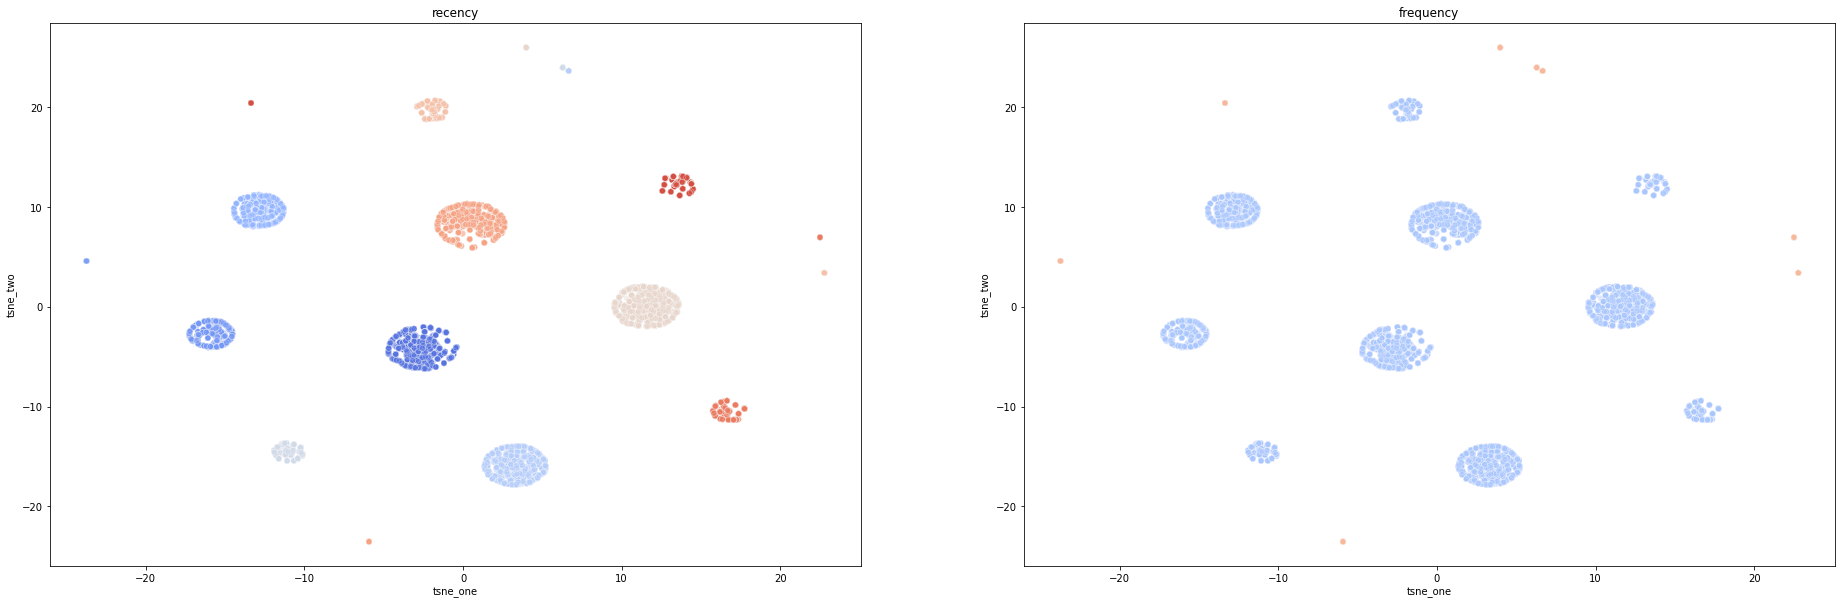

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
 
%matplotlib inline
 
# configure plot as three charts in a single row
f, axes = plt.subplots(nrows=1, ncols=2, squeeze=True, figsize=(32,10))
 
for i, metric in enumerate(['recency', 'frequency']):
  
  # unique values for this metric
  n = scores_pd[['{0}_score'.format(metric)]].nunique()[0]
  
  # use metric name as chart title
  axes[i].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x='tsne_one',
    y='tsne_two',
    hue='{0}_score'.format(metric),
    palette=sns.color_palette('coolwarm', n),
    data=scores_pd,
    legend=False,
    alpha=0.4,
    ax = axes[i]
    )

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
 
# function to train and score clusters based on k cluster count
def train_model( k ):
    km = KMeans(
    n_clusters=k, 
    init='random',
    n_init=1000
    )
    kmeans = km.fit_predict( inputs_broadcast.value )
    silhouette = silhouette_score( inputs_broadcast.value , kmeans)
    return (k, float(silhouette))
 
# assemble an rdd containing 5 instances of each k value from 2 to 20
rdd = (
  spark
    .range(2, 21, step=1, numPartitions=sc.defaultParallelism)
    .withColumnRenamed('id','k')
    .crossJoin( spark.range(0, 5) )
    .select('k')
    .rdd
    .map(lambda k: int(k[0]))
  )
 
# distribute the dataset on which we will perform our evaluation
inputs_pd = scores_pd[['recency_score', 'frequency_score']]
inputs_broadcast = sc.broadcast(inputs_pd)
 
# perform the training/evaluation work
results = rdd.map(train_model)
 
# release the distributed dataset
inputs_broadcast.unpersist()
 
# display the results of our analysis
#display( spark.createDataFrame( results, schema=['clusters','silhouette']) )

In [ ]:
x=spark.createDataFrame( results, schema=['clusters','silhouette'])
#results.take(20)

In [35]:
km = KMeans(
  n_clusters=8, 
  init='random',
  n_init=1000
  )
_ = km.fit( inputs_pd )

In [36]:
scores_pd['cluster'] = km.predict( inputs_pd )
scores_pd.head()

,recency_score,frequency_score,tsne_one,tsne_two,cluster
ncodpers,,,,,
15890,2,1,-14.909120,-5.941194,7
15892,3,1,-7.601157,17.204138,0
15899,4,1,5.898059,12.407422,3
15900,8,1,12.943104,-0.085122,4
15918,2,1,-14.254489,-5.923096,7


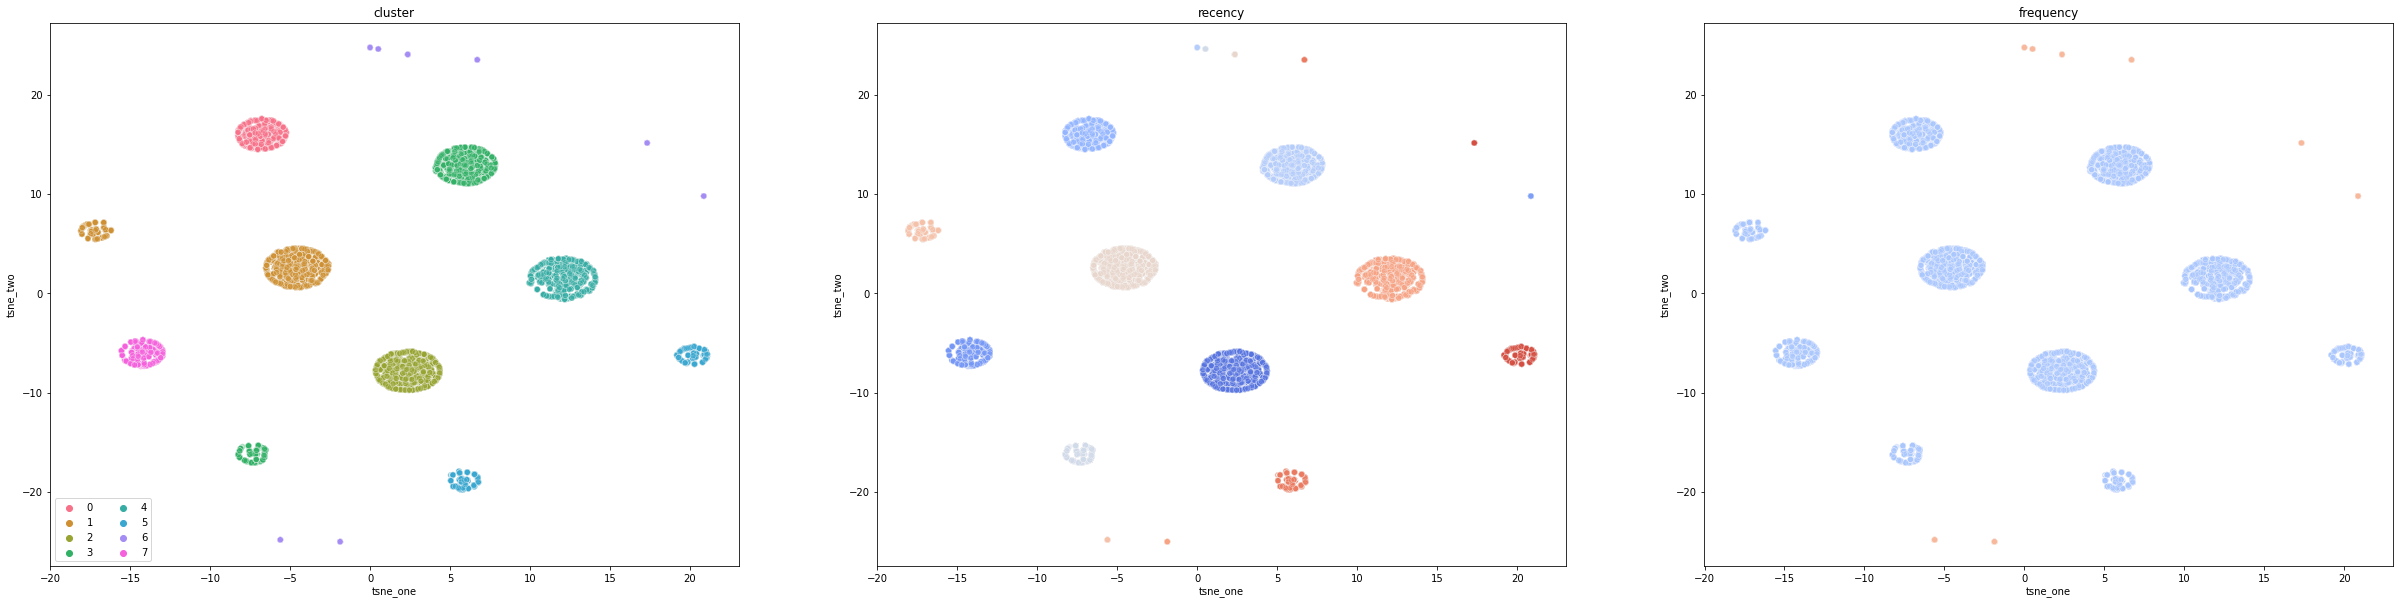

In [39]:
f, axes = plt.subplots(nrows=1, ncols=3, squeeze=True, figsize=(42, 10))
 
# chart the cluster assignments
axes[0].set_title('cluster')
sns.scatterplot(
  x='tsne_one',
  y='tsne_two',
  hue='cluster',
  palette=sns.color_palette('husl', scores_pd[['cluster']].nunique()[0]),
  data=scores_pd,
  legend='brief',
  alpha=0.4,
  ax = axes[0]
  )
axes[0].legend(loc='lower left', ncol=2, fancybox=True)
 
# chart the RFM scores
for i, metric in enumerate(['recency', 'frequency']):
  
  # unique values for this metric
  n = scores_pd[['{0}_score'.format(metric)]].nunique()[0]
  
  # use metric name as chart title
  axes[i+1].set_title(metric)
  
  # define chart
  sns.scatterplot(
    x='tsne_one',
    y='tsne_two',
    hue='{0}_score'.format(metric),
    palette=sns.color_palette('coolwarm', n),
    data=scores_pd,
    legend=False,
    alpha=0.4,
    ax = axes[i+1]
    )


In [40]:
# generate cluster numbers
clusters = map(lambda c: 'Cluster {}'.format(c), range(0, km.n_clusters))
 
# extract cluster centroids
metrics = {0:'R', 1:'F'}
centroids = map(lambda scores: ', '.join(['{}: {:.1f}'.format(metrics[i], s) for i,s in enumerate(scores)]) , km.cluster_centers_)
 
# combine cluster number with centroid info
list(zip(clusters, centroids))


[('Cluster 0', 'R: 3.0, F: 1.0'),
 ('Cluster 1', 'R: 6.3, F: 1.0'),
 ('Cluster 2', 'R: 1.0, F: 1.0'),
 ('Cluster 3', 'R: 4.3, F: 1.0'),
 ('Cluster 4', 'R: 8.0, F: 1.0'),
 ('Cluster 5', 'R: 9.5, F: 1.0'),
 ('Cluster 6', 'R: 6.8, F: 10.0'),
 ('Cluster 7', 'R: 2.0, F: 1.0')]